In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

In [5]:
batch_fname = BASEDIR / "inputs/short_answer/claude-3-5-haiku-20241022/batch.jsonl"
fname = BASEDIR / "outputs/short_answer/claude-3-5-haiku-20241022/outputs.jsonl"

batches = read_jsonl(batch_fname)
responses = read_jsonl(fname)
responses = [
    {
        "uid": resp["custom_id"].replace("-", "/"),
        "system": prompt["params"]["system"],
        "prompt": prompt["params"]["messages"],
        "response": ModelResponse.from_response(resp["result"]["message"], "anthropic", use_batch_api=True)
    }
    for prompt, resp in zip(batches, responses)
    if resp["custom_id"].replace("-", "/") in dataset_map
]
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset)

  0%|          | 0/4780 [00:00<?, ?it/s]

Function timed out after 10 seconds
(" Let's solve this step by step:\n\n1) For $\\log_{2001}{x}$ to be defined, we need $x > 1$\n\n2) For $\\log_{2002}(\\log_{2001}{x})$ to be defined, we need $\\log_{2001}{x} > 1$\n   • This means $x > 2001^1 = 2001$\n\n3) For $\\log_{2003}(\\log_{2002}(\\log_{2001}{x}))$ to be defined, we need $\\log_{2002}(\\log_{2001}{x}) > 1$\n   • This means $\\log_{2001}{x} > 2002^1 = 2002$\n   • This means $x > 2001^{2002}$\n\n4) For $\\log_{2004}(\\log_{2003}(\\log_{2002}(\\log_{2001}{x})))$ to be defined, we need $\\log_{2003}(\\log_{2002}(\\log_{2001}{x})) > 1$\n   • This means $\\log_{2002}(\\log_{2001}{x}) > 2003^1 = 2003$\n   • This means $\\log_{2001}{x} > 2002^{2003}$\n   • This means $x > 2001^{2002^{2003}}$\n\n5) Therefore, $c = 2001^{2002^{2003}}$\n\nAnswer: $2001^{2002^{2003}}$", '$2001^{2002}$') {'extract_policy': 'flex', 'eval_policy': 'aggressive', 'debug': False}


0.37845188284518827

In [6]:
os.makedirs(BASEDIR / "results/claude-3-5-haiku-20241022", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/claude-3-5-haiku-20241022/results.csv")

In [7]:
results_metadata.value_counts("reason")

reason
stop      4777
length       3
Name: count, dtype: int64

## Cost

In [8]:
PRICES = get_pricing("claude-3-5-haiku-20241022")

total_cost = 0
for row in results_metadata.itertuples():
    total_cost += PRICES["input_tokens"] * row.input_tokens
    total_cost += PRICES["output_tokens"] * row.output_tokens
total_cost / 2  # divide by 2 for Batch API

4.892824000000019

## Accuracy

In [9]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,66.082603
2,1505,50.897010
3,1363,29.493764
4,719,12.517385
5,197,8.121827
6,197,3.553299


In [10]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,39.278351
counting_and_probability,812,30.911330
geometry,1268,26.971609
number_theory,601,33.444260
prealgebra,889,66.479190
precalculus,240,17.916667


## Output lengths

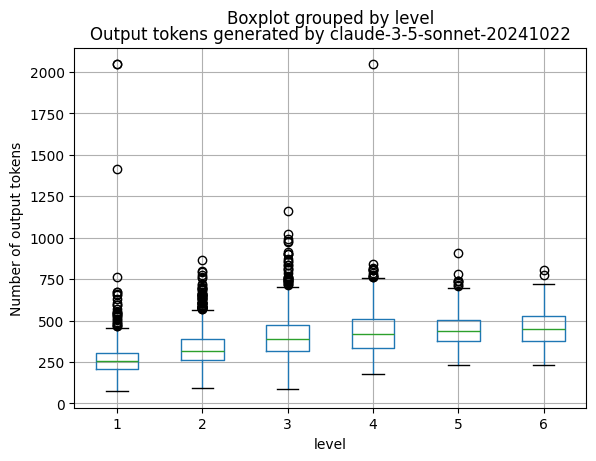

In [11]:
results_metadata.boxplot("output_tokens", "level")
plt.title("Output tokens generated by claude-3-5-sonnet-20241022")
plt.ylabel("Number of output tokens")
plt.show()

<Figure size 900x600 with 0 Axes>

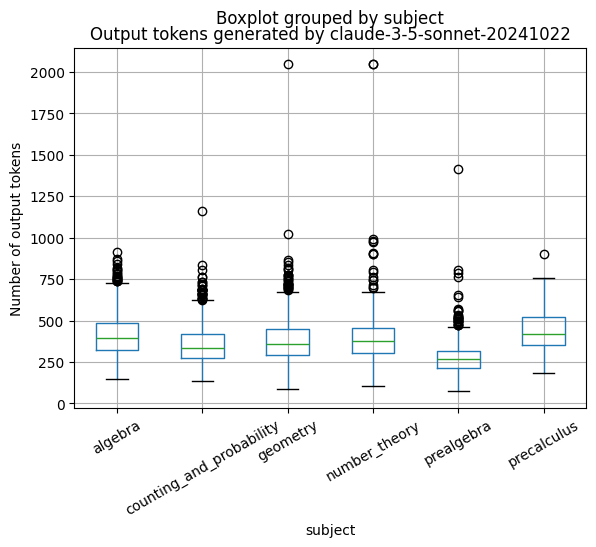

In [12]:
plt.figure(figsize=(9,6))
results_metadata.boxplot("output_tokens", "subject")
plt.title("Output tokens generated by claude-3-5-sonnet-20241022")
plt.ylabel("Number of output tokens")
plt.xticks(rotation=30)
plt.show()